**Imports**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import cv2
import numpy as np
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

**Optimizers**

In [ ]:
def adam_opt(model,l_rate):
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=l_rate,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-07)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def rms_prop(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.RMSprop(
      learning_rate=l_rate,
      rho=0.9,
      epsilon=1e-07)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model
  
def momentum_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.9,
      nesterov=False) #################
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model

def vanilla_gd(model,l_rate):
  optimizer = tf.keras.optimizers.experimental.SGD(
      learning_rate=l_rate,
      momentum=0.0)
  model.compile(
      optimizer=optimizer, 
      loss=tf.keras.losses.sparse_categorical_crossentropy, 
      metrics=['accuracy']
  )
  return model


**Data Preprocessing**

In [ ]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Select 500 images per class from the training set
num_classes = 10
num_samples_per_class = 500
x_train_tiny = np.zeros((num_classes*num_samples_per_class, 32, 32, 3))
y_train_tiny = np.zeros((num_classes*num_samples_per_class, 1))
for class_idx in range(num_classes):
    class_indices = np.where(y_train == class_idx)[0]
    random_indices = np.random.choice(class_indices, num_samples_per_class, replace=False)
    x_train_tiny[class_idx*num_samples_per_class:(class_idx+1)*num_samples_per_class,:,:,:] = x_train[random_indices,:,:,:]
    y_train_tiny[class_idx*num_samples_per_class:(class_idx+1)*num_samples_per_class,:] = y_train[random_indices,:]

# Use the same 10,000 images for testing as per the CIFAR-10 dataset
X_test = x_test
Y_test = y_test

X_train = x_train_tiny
Y_train = y_train_tiny
# print(np.where(y_train == 0))

#Normalizing data
mean = np.mean(X_train, axis=(0, 1, 2))
std = np.std(X_train, axis=(0, 1, 2))
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std  ####################

n_rows = X_train.shape[0]
perm = np.random.permutation(n_rows)
X_train = X_train[perm]
Y_train = Y_train[perm]



X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.16666, random_state=42)


print("X_train shape: ",X_train.shape)
print("Y_train shape: ",Y_train.shape)
print("X_test shape: ",X_test.shape)
print("Y_test shape: ",Y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
X_train shape:  (4166, 32, 32, 3)
Y_train shape:  (4166, 1)
X_test shape:  (10000, 32, 32, 3)
Y_test shape:  (10000, 1)


**Implementing ResNet-18 architecture**

When we increase the number of layers, there is a common problem in deep learning associated with that called the Vanishing/Exploding gradient. This causes the gradient to become 0 or too large. Thus when we increases number of layers, the training and test error rate also increases. 

In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Blocks. In this network, we use a technique called skip connections. The skip connection connects activations of a  layer to further layers by skipping some layers in between. This forms a residual block. Resnets are made by stacking these residual blocks together.

The advantage of adding this type of skip connection is that if any layer hurt the performance of architecture then it will be skipped by regularization. So, this results in training a very deep neural network without the problems caused by vanishing/exploding gradient.

Apart from the vanishing gradients, there is another reason that we commonly use them. For a plethora of tasks there is some information that was captured in the initial layers and we would like to allow the later layers to also learn from them.

In ResNet-18, downsample is used in the residual blocks where the stride is greater than 1. When the stride is greater than 1, the convolutional layer reduces the spatial dimensions of the input feature map. However, the shortcut connection (i.e., the skip connection) requires the output of the convolutional layer to have the same dimensions as the input feature map. To achieve this, downsample is used to perform spatial downsampling on the input feature map before adding it to the output of the convolutional layer.

**For Implementing this architecture we use functional API instead of sequential API** because of its flexiblity.

ResNet18 is a neural network architecture that consists of 18 layers, which are:

1. Convolutional layer with 64 filters and kernel size of 7x7
Batch normalization layer
2. Rectified Linear Unit (ReLU) activation function
3. Max pooling layer with pool size of 3x3 and stride of 2
4. 2 ResNet blocks, each containing 2 convolutional layers with 64 filters, kernel size of 3x3 and stride of 1, followed by batch normalization and ReLU activation function
5. 2 ResNet blocks, each containing 2 convolutional layers with 128 filters, kernel size of 3x3 and stride of 2 (except for the first layer in each block which has a stride of 2), followed by batch normalization and ReLU activation function
6. 2 ResNet blocks, each containing 2 convolutional layers with 256 filters, kernel size of 3x3 and stride of 2 (except for the first layer in each block which has a stride of 2), followed by batch normalization and ReLU activation function
7. 2 ResNet blocks, each containing 2 convolutional layers with 512 filters, kernel size of 3x3 and stride of 2 (except for the first layer in each block which has a stride of 2), followed by batch normalization and ReLU activation function
8. Global average pooling layer
9. Fully connected layer with 10 units and softmax activation function


Note that some of the layers in ResNet18 are repeated, which is why there are a total of 18 layers in the architecture.

In [ ]:
def residual_block(x, filters, stride, downsample=None): #H(x) = F(x)+x
    residual = x 

    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=stride, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if downsample is not None:
        residual = downsample(residual)

    x = tf.keras.layers.Add()([x, residual]) #does element-wise addition
    x = tf.keras.layers.Activation('relu')(x)

    return x

def ResNet18(num_classes,input_shape = (32,32,3)):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(input_tensor) #layer-1
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters = 64 #layer 2-5
    x = residual_block(x, filters,stride=1)
    x = residual_block(x, filters,stride=1)

    filters *= 2 #layer 6-9
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2,downsample=downsample)
    x = residual_block(x, filters,stride=1)

    filters *= 2 #layer 10-13
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    filters *= 2 #layer 14-17
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(num_classes, activation='softmax')(x) #layer-18

    model = tf.keras.models.Model(input_tensor, output_tensor)

    return model

def ResNet18_d(num_classes,x1,x2,x3,x4,dr,input_shape = (32,32,3)):
    input_tensor = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(input_tensor) #layer-1
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    filters = 64 #layer 2-5
    x = residual_block(x, filters,stride=1)
    x = residual_block(x, filters,stride=1)

    if(x1==1):
      x=tf.keras.layers.Dropout(dr)(x)

    filters *= 2 #layer 6-9
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2,downsample=downsample)
    x = residual_block(x, filters,stride=1)

    if(x2==1):
      x=tf.keras.layers.Dropout(dr)(x)

    filters *= 2 #layer 10-13
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    if(x3==1):
      x=tf.keras.layers.Dropout(dr)(x)

    filters *= 2 #layer 14-17
    downsample = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=2, padding='same')
    x = residual_block(x, filters, stride=2, downsample=downsample)
    x = residual_block(x, filters,stride=1)

    if(x4==1):
      x=tf.keras.layers.Dropout(dr)(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    output_tensor = tf.keras.layers.Dense(num_classes, activation='softmax')(x) #layer-18

    model = tf.keras.models.Model(input_tensor, output_tensor)

    return model



    

In [ ]:

h=[]

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

# for dropout_rate in dropout_rates:
    # Add dropout after the second and third block
model = ResNet18_d(num_classes,0,0,0,0,0)
    
model = adam_opt(model,0.00001)

history = SaveAccuracyCallback()
history.acc = []
history.val_acc = []

    # Train the model with data augmentation
model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=32,epochs=100,verbose=1,callbacks=[history])
h.append(history)

    # Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # Print the test accuracy
print(f'Test accuracy : {test_acc:.4f}')

Epoch 1/100
131/131 [==============================] - 25s 27ms/step - loss: 2.9707 - accuracy: 0.1644 - val_loss: 2.3328 - val_accuracy: 0.1163
Epoch 2/100
131/131 [==============================] - 3s 20ms/step - loss: 1.9854 - accuracy: 0.3332 - val_loss: 2.2422 - val_accuracy: 0.1427
Epoch 3/100
131/131 [==============================] - 3s 25ms/step - loss: 1.6231 - accuracy: 0.4325 - val_loss: 2.0325 - val_accuracy: 0.2482
Epoch 4/100
131/131 [==============================] - 3s 20ms/step - loss: 1.3539 - accuracy: 0.5420 - val_loss: 1.9494 - val_accuracy: 0.3153
Epoch 5/100
131/131 [==============================] - 3s 21ms/step - loss: 1.1724 - accuracy: 0.6083 - val_loss: 1.9772 - val_accuracy: 0.3429
Epoch 6/100
131/131 [==============================] - 3s 25ms/step - loss: 1.0009 - accuracy: 0.6851 - val_loss: 1.9923 - val_accuracy: 0.3405
Epoch 7/100
131/131 [==============================] - 3s 24ms/step - loss: 0.8625 - accuracy: 0.7309 - val_loss: 1.9691 - val_accuracy

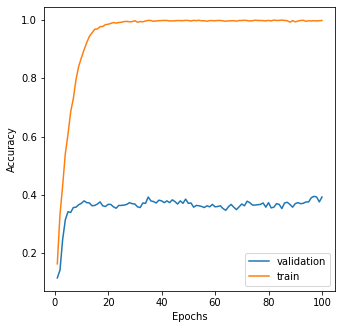

In [9]:
fig1 = plt.figure(figsize = (24,24))
ax1 = fig1.add_subplot(4,4,1)



ax1.plot(np.arange(1,100+1), h[0].val_acc)
ax1.plot(np.arange(1,100+1), h[0].acc)
ax1.set(xlabel='Epochs', ylabel='Accuracy')
ax1.legend(['validation','train'])

plt.show()

**Dropout after layer-5**

In [ ]:

dropout_rates = [0.1,0.3,0.5,0.7]
h=[]

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

for dropout_rate in dropout_rates:
    # Add dropout after the second and third block
    model = ResNet18_d(num_classes,1,0,0,0,dropout_rate)
    
    model = adam_opt(model,0.00001)

    history = SaveAccuracyCallback()
    history.acc = []
    history.val_acc = []

    # Train the model with data augmentation
    model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=32,epochs=100,verbose=1,callbacks=[history])
    h.append(history)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # Print the test accuracy and dropout rate
    print(f'Test accuracy with dropout rate {dropout_rate}: {test_acc:.4f}')

# 

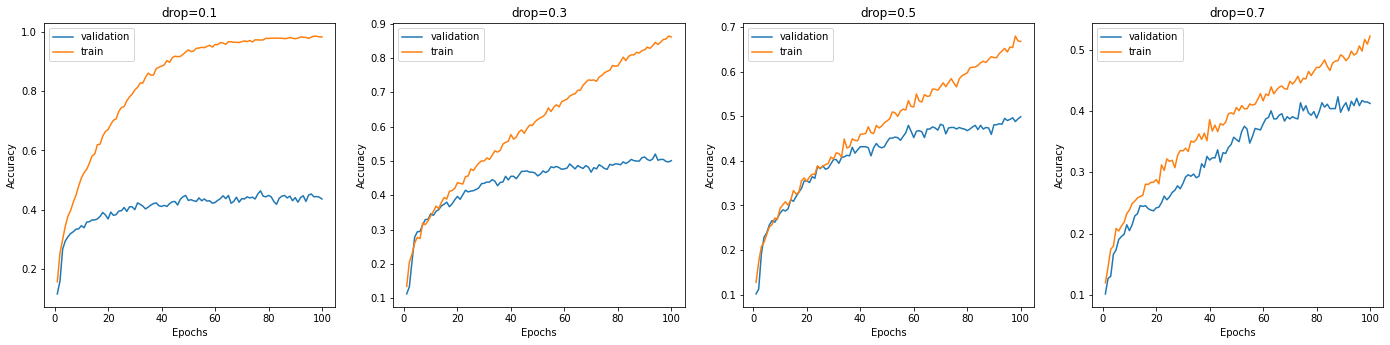

In [ ]:
fig1 = plt.figure(figsize = (24,24))
ax1 = fig1.add_subplot(4,4,1)
ax2 = fig1.add_subplot(4,4,2)
ax3 = fig1.add_subplot(4,4,3)
ax4 = fig1.add_subplot(4,4,4)


ax1.plot(np.arange(1,100+1), h[0].val_acc)
ax1.plot(np.arange(1,100+1), h[0].acc)
ax1.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.1')
ax1.legend(['validation','train'])

ax2.plot(np.arange(1,100+1), h[1].val_acc)
ax2.plot(np.arange(1,100+1), h[1].acc)
ax2.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.3')
ax2.legend(['validation','train'])

ax3.plot(np.arange(1,100+1), h[2].val_acc)
ax3.plot(np.arange(1,100+1), h[2].acc)
ax3.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.5')
ax3.legend(['validation','train'])

ax4.plot(np.arange(1,100+1), h[3].val_acc)
ax4.plot(np.arange(1,100+1), h[3].acc)
ax4.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.7')
ax4.legend(['validation','train'])

plt.show()

**Dropout after layer-9**

In [ ]:
dropout_rates = [0.1,0.3,0.5,0.7]
h=[]

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

for dropout_rate in dropout_rates:
    # Add dropout after the second and third block
    model = ResNet18_d(num_classes,0,1,0,0,dropout_rate)
    
    model = adam_opt(model,0.00001)

    history = SaveAccuracyCallback()
    history.acc = []
    history.val_acc = []

    # Train the model with data augmentation
    model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=32,epochs=100,verbose=1,callbacks=[history])
    h.append(history)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # Print the test accuracy and dropout rate
    print(f'Test accuracy with dropout rate {dropout_rate}: {test_acc:.4f}')

Epoch 1/100
131/131 [==============================] - 15s 26ms/step - loss: 3.0470 - accuracy: 0.1356 - val_loss: 2.3162 - val_accuracy: 0.1115
Epoch 2/100
131/131 [==============================] - 3s 22ms/step - loss: 2.2742 - accuracy: 0.2386 - val_loss: 2.2814 - val_accuracy: 0.1643
Epoch 3/100
131/131 [==============================] - 4s 27ms/step - loss: 2.0179 - accuracy: 0.3036 - val_loss: 2.0766 - val_accuracy: 0.2470
Epoch 4/100
131/131 [==============================] - 3s 22ms/step - loss: 1.8393 - accuracy: 0.3603 - val_loss: 1.9598 - val_accuracy: 0.2938
Epoch 5/100
131/131 [==============================] - 3s 23ms/step - loss: 1.7160 - accuracy: 0.3973 - val_loss: 1.9126 - val_accuracy: 0.3177
Epoch 6/100
131/131 [==============================] - 3s 22ms/step - loss: 1.6129 - accuracy: 0.4294 - val_loss: 1.9233 - val_accuracy: 0.3297
Epoch 7/100
131/131 [==============================] - 3s 26ms/step - loss: 1.4927 - accuracy: 0.4806 - val_loss: 1.8969 - val_accuracy

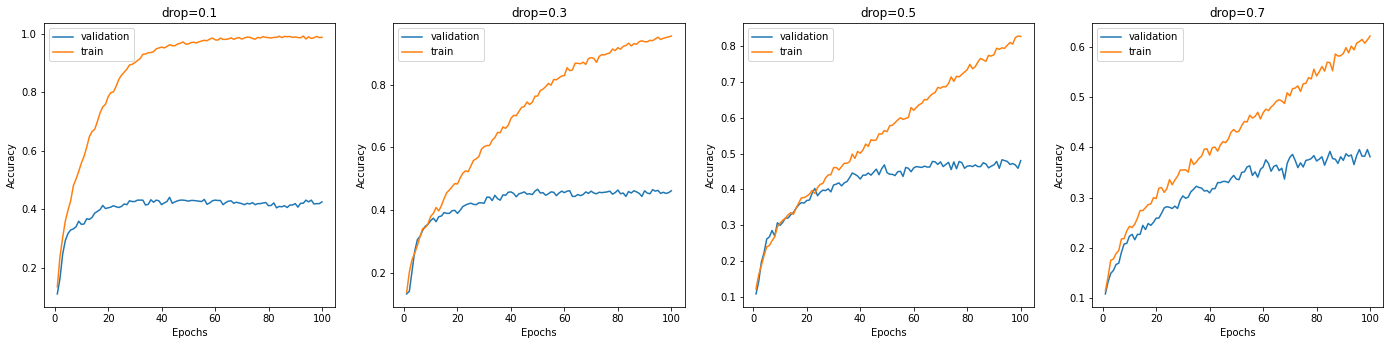

In [ ]:
fig1 = plt.figure(figsize = (24,24))
ax1 = fig1.add_subplot(4,4,1)
ax2 = fig1.add_subplot(4,4,2)
ax3 = fig1.add_subplot(4,4,3)
ax4 = fig1.add_subplot(4,4,4)


ax1.plot(np.arange(1,100+1), h[0].val_acc)
ax1.plot(np.arange(1,100+1), h[0].acc)
ax1.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.1')
ax1.legend(['validation','train'])

ax2.plot(np.arange(1,100+1), h[1].val_acc)
ax2.plot(np.arange(1,100+1), h[1].acc)
ax2.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.3')
ax2.legend(['validation','train'])

ax3.plot(np.arange(1,100+1), h[2].val_acc)
ax3.plot(np.arange(1,100+1), h[2].acc)
ax3.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.5')
ax3.legend(['validation','train'])

ax4.plot(np.arange(1,100+1), h[3].val_acc)
ax4.plot(np.arange(1,100+1), h[3].acc)
ax4.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.7')
ax4.legend(['validation','train'])

plt.show()

**Dropout after layer-13**

In [ ]:
dropout_rates = [0.1,0.3,0.5,0.7]
h=[]

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

for dropout_rate in dropout_rates:
    # Add dropout after the second and third block
    model = ResNet18_d(num_classes,0,0,1,0,dropout_rate)
    
    model = adam_opt(model,0.00001)

    history = SaveAccuracyCallback()
    history.acc = []
    history.val_acc = []

    # Train the model with data augmentation
    model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=32,epochs=100,verbose=1,callbacks=[history])
    h.append(history)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # Print the test accuracy and dropout rate
    print(f'Test accuracy with dropout rate {dropout_rate}: {test_acc:.4f}')

Epoch 1/100
131/131 [==============================] - 14s 25ms/step - loss: 2.9584 - accuracy: 0.1596 - val_loss: 2.3153 - val_accuracy: 0.1031
Epoch 2/100
131/131 [==============================] - 3s 23ms/step - loss: 2.1851 - accuracy: 0.2708 - val_loss: 2.2844 - val_accuracy: 0.1499
Epoch 3/100
131/131 [==============================] - 3s 23ms/step - loss: 1.8970 - accuracy: 0.3555 - val_loss: 2.0865 - val_accuracy: 0.2326
Epoch 4/100
131/131 [==============================] - 3s 22ms/step - loss: 1.6724 - accuracy: 0.4155 - val_loss: 1.9958 - val_accuracy: 0.2782
Epoch 5/100
131/131 [==============================] - 3s 21ms/step - loss: 1.5349 - accuracy: 0.4683 - val_loss: 1.9399 - val_accuracy: 0.3165
Epoch 6/100
131/131 [==============================] - 3s 22ms/step - loss: 1.4049 - accuracy: 0.5125 - val_loss: 1.9438 - val_accuracy: 0.3249
Epoch 7/100
131/131 [==============================] - 3s 23ms/step - loss: 1.2798 - accuracy: 0.5643 - val_loss: 1.9271 - val_accuracy

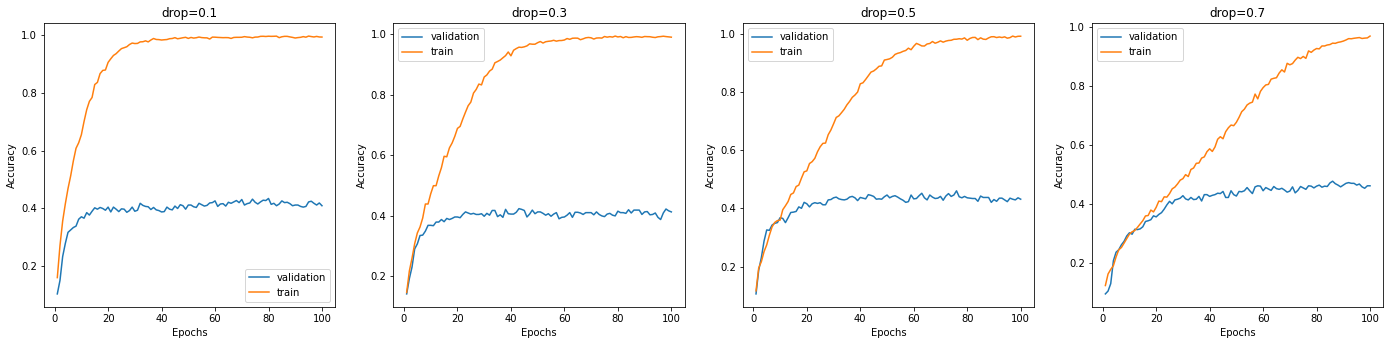

In [ ]:
fig1 = plt.figure(figsize = (24,24))
ax1 = fig1.add_subplot(4,4,1)
ax2 = fig1.add_subplot(4,4,2)
ax3 = fig1.add_subplot(4,4,3)
ax4 = fig1.add_subplot(4,4,4)


ax1.plot(np.arange(1,100+1), h[0].val_acc)
ax1.plot(np.arange(1,100+1), h[0].acc)
ax1.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.1')
ax1.legend(['validation','train'])

ax2.plot(np.arange(1,100+1), h[1].val_acc)
ax2.plot(np.arange(1,100+1), h[1].acc)
ax2.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.3')
ax2.legend(['validation','train'])

ax3.plot(np.arange(1,100+1), h[2].val_acc)
ax3.plot(np.arange(1,100+1), h[2].acc)
ax3.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.5')
ax3.legend(['validation','train'])

ax4.plot(np.arange(1,100+1), h[3].val_acc)
ax4.plot(np.arange(1,100+1), h[3].acc)
ax4.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.7')
ax4.legend(['validation','train'])

plt.show()

**Dropout after layer-17**

In [ ]:
dropout_rates = [0.1,0.3,0.5,0.7]
h=[]

class SaveAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

for dropout_rate in dropout_rates:
    # Add dropout after the second and third block
    model = ResNet18_d(num_classes,0,0,0,1,dropout_rate)
    
    model = adam_opt(model,0.00001)

    history = SaveAccuracyCallback()
    history.acc = []
    history.val_acc = []

    # Train the model with data augmentation
    model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=32,epochs=100,verbose=1,callbacks=[history])
    h.append(history)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)

    # Print the test accuracy and dropout rate
    print(f'Test accuracy with dropout rate {dropout_rate}: {test_acc:.4f}')

Epoch 1/100
131/131 [==============================] - 14s 26ms/step - loss: 2.8574 - accuracy: 0.1563 - val_loss: 2.3018 - val_accuracy: 0.1259
Epoch 2/100
131/131 [==============================] - 3s 23ms/step - loss: 2.1404 - accuracy: 0.2952 - val_loss: 2.2354 - val_accuracy: 0.1811
Epoch 3/100
131/131 [==============================] - 3s 23ms/step - loss: 1.8208 - accuracy: 0.3745 - val_loss: 2.0457 - val_accuracy: 0.2734
Epoch 4/100
131/131 [==============================] - 3s 21ms/step - loss: 1.5780 - accuracy: 0.4446 - val_loss: 2.0044 - val_accuracy: 0.2914
Epoch 5/100
131/131 [==============================] - 3s 21ms/step - loss: 1.3801 - accuracy: 0.5154 - val_loss: 2.0209 - val_accuracy: 0.3177
Epoch 6/100
131/131 [==============================] - 3s 24ms/step - loss: 1.2015 - accuracy: 0.5835 - val_loss: 2.0136 - val_accuracy: 0.3129
Epoch 7/100
131/131 [==============================] - 3s 21ms/step - loss: 1.0682 - accuracy: 0.6421 - val_loss: 2.0135 - val_accuracy

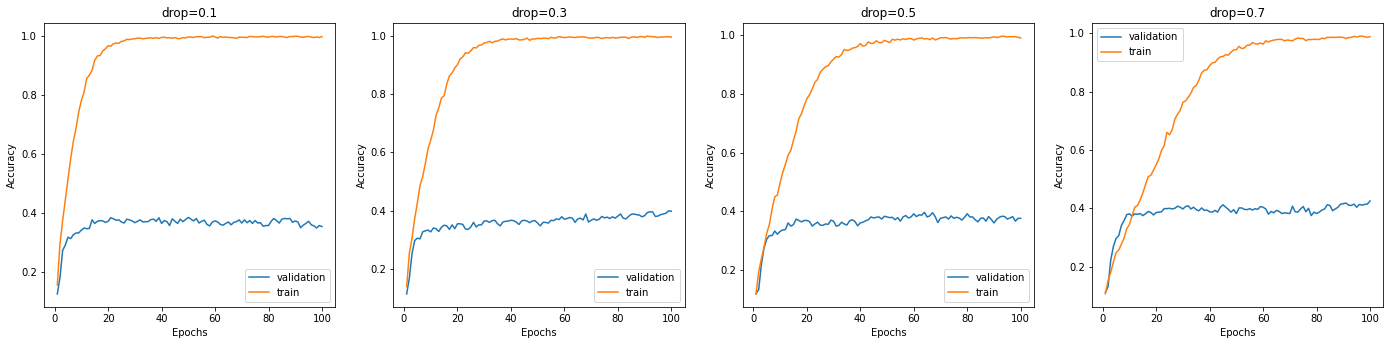

In [ ]:
fig1 = plt.figure(figsize = (24,24))
ax1 = fig1.add_subplot(4,4,1)
ax2 = fig1.add_subplot(4,4,2)
ax3 = fig1.add_subplot(4,4,3)
ax4 = fig1.add_subplot(4,4,4)


ax1.plot(np.arange(1,100+1), h[0].val_acc)
ax1.plot(np.arange(1,100+1), h[0].acc)
ax1.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.1')
ax1.legend(['validation','train'])

ax2.plot(np.arange(1,100+1), h[1].val_acc)
ax2.plot(np.arange(1,100+1), h[1].acc)
ax2.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.3')
ax2.legend(['validation','train'])

ax3.plot(np.arange(1,100+1), h[2].val_acc)
ax3.plot(np.arange(1,100+1), h[2].acc)
ax3.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.5')
ax3.legend(['validation','train'])

ax4.plot(np.arange(1,100+1), h[3].val_acc)
ax4.plot(np.arange(1,100+1), h[3].acc)
ax4.set(xlabel='Epochs', ylabel='Accuracy',
        title='drop=0.7')
ax4.legend(['validation','train'])

plt.show()